<a href="https://colab.research.google.com/github/KrisDcosta/Stock_Prediction_Project/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Installing the yfinance library
!pip install pandas numpy matplotlib seaborn scikit-learn yfinance

In [32]:
# Import all necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Set Seaborn style for better visualization
sns.set_style("darkgrid")

In [33]:
# Define the stock ticker symbol
ticker = "GOOGL"

try:
    data = yf.download(ticker, start="2014-01-01", end="2023-5-31")
    print(f"\nData for {ticker} downloaded successfully.")
except Exception as e:
    print(f"Error fetching data: {e}")

[*********************100%***********************]  1 of 1 completed


Data for GOOGL downloaded successfully.


In [34]:
import pandas as pd
data.head(5)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2014-01-02 00:00:00+00:00,27.787050,27.855856,27.971722,27.734234,27.914413,72783144
2014-01-03 00:00:00+00:00,27.584349,27.652653,27.951200,27.650902,27.902903,66601332
2014-01-06 00:00:00+00:00,27.891895,27.960960,27.999498,27.688688,27.853104,70701228
2014-01-07 00:00:00+00:00,28.429604,28.500000,28.520771,28.057056,28.153152,102001896
2014-01-08 00:00:00+00:00,28.488768,28.559309,28.711712,28.360611,28.678679,89610300


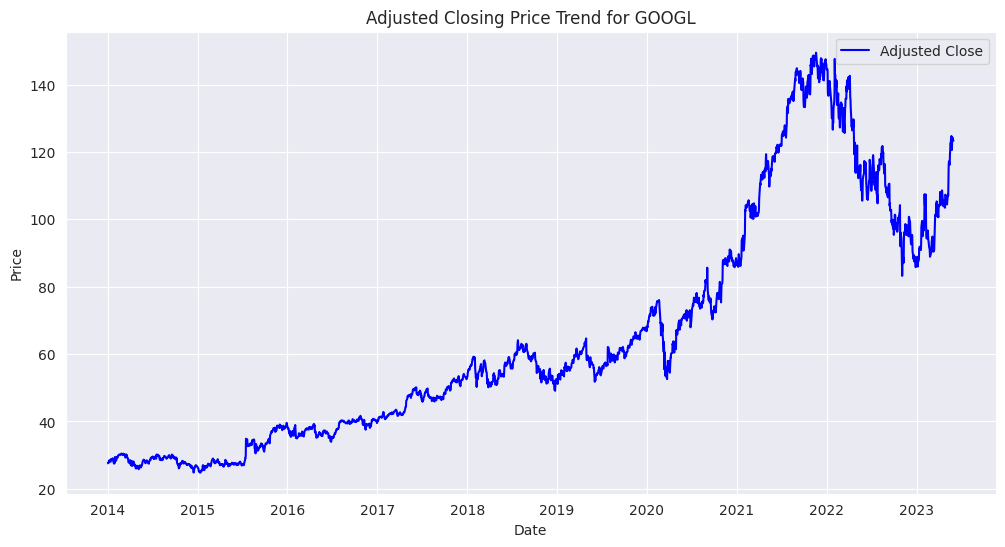

In [35]:
# Visualize the closing price trend

plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Adj Close"], color="blue", label="Adjusted Close")
plt.title(f"Adjusted Closing Price Trend for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
data1 = data[["Adj Close"]]
data1.head(5)

Price,Adj Close
Ticker,GOOGL
Date,
2014-01-02 00:00:00+00:00,27.787050
2014-01-03 00:00:00+00:00,27.584349
2014-01-06 00:00:00+00:00,27.891895
2014-01-07 00:00:00+00:00,28.429604
2014-01-08 00:00:00+00:00,28.488768


In [37]:
# Feature Engineering: Create target variable
data1["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]

# Display the first few rows of new 'Target' column
data1.head(5)

<ipython-input-37-a3d6e08ac46a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]


Price,Adj Close,Target
Ticker,GOOGL,
Date,,
2014-01-02 00:00:00+00:00,27.787050,NaN
2014-01-03 00:00:00+00:00,27.584349,0.0
2014-01-06 00:00:00+00:00,27.891895,1.0
2014-01-07 00:00:00+00:00,28.429604,1.0
2014-01-08 00:00:00+00:00,28.488768,1.0


In [38]:
# Feature Engineering: Create lagged features using previous day's data
data_prev = data.copy()
data_prev = data_prev.shift(1)
data_prev.head(5)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2014-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03 00:00:00+00:00,27.787050,27.855856,27.971722,27.734234,27.914413,72783144.0
2014-01-06 00:00:00+00:00,27.584349,27.652653,27.951200,27.650902,27.902903,66601332.0
2014-01-07 00:00:00+00:00,27.891895,27.960960,27.999498,27.688688,27.853104,70701228.0
2014-01-08 00:00:00+00:00,28.429604,28.500000,28.520771,28.057056,28.153152,102001896.0


In [39]:
# Define predictor variables (features used for prediction)
predictors = ["Adj Close", "Volume", "Open", "High", "Low","Close"]

# Merge lagged features with original data
data1 = data1.merge(data_prev[predictors]).iloc[1:]

# Display predictor values
predictors

['Adj Close', 'Volume', 'Open', 'High', 'Low', 'Close']

In [40]:
# Defining the backtesting function
def backtest(data, model=None, predictors=None, start=1000, step=750):

    if model is None:
        model = HistGradientBoostingClassifier()

    predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the model on the training data
        model.fit(train[predictors], train["Target"])

        # Make predictions on the test data
        preds = model.predict_proba(test[predictors])[:, 1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > 0.6] = 1 # Thresholds ato classify as a buy signal
        preds[preds <= 0.6] = 0 # Thresholds ato classify as a sell signal

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)


In [41]:
predictions = backtest(data1,None, predictors)

-----------Predictions without feature engineering-----------
Accuracy: 0.5084269662921348

Precision: 0.5491329479768786

Recall: 0.3794940079893475

F1 Score: 0.44881889763779526

ROC AUC Score: 0.5158985641729799

Classification Report:               precision    recall  f1-score   support

         0.0       0.49      0.65      0.56       673
         1.0       0.55      0.38      0.45       751

    accuracy                           0.51      1424
   macro avg       0.52      0.52      0.50      1424
weighted avg       0.52      0.51      0.50      1424




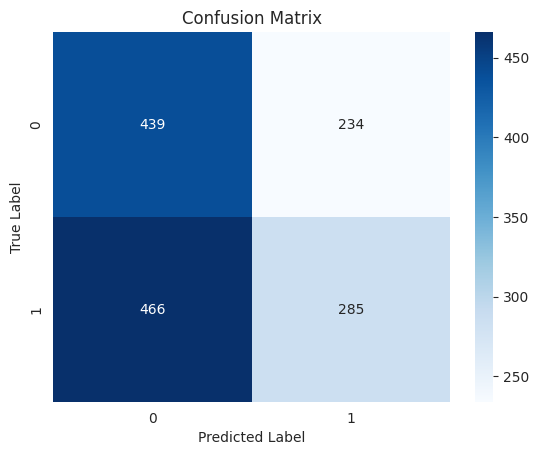

In [42]:
def evaluate(predictions, title, s):
  # Evaluate the models' peformance using various performance metrics
  accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
  precision = precision_score(predictions["Target"], predictions["Predictions"])
  recall = recall_score(predictions["Target"], predictions["Predictions"])
  f1 = f1_score(predictions["Target"], predictions["Predictions"])
  roc_auc = roc_auc_score(predictions["Target"], predictions["Predictions"])
  confusion = confusion_matrix(predictions["Target"], predictions["Predictions"])
  classification = classification_report(predictions["Target"], predictions["Predictions"])
  print(f"-----------Predictions {s} feature engineering-----------")
  print(f"Accuracy: {accuracy}\n")
  print(f"Precision: {precision}\n")
  print(f"Recall: {recall}\n")
  print(f"F1 Score: {f1}\n")
  print(f"ROC AUC Score: {roc_auc}\n")
  print(f"Classification Report: {classification}\n")

  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

s = 'without'
evaluate(predictions, ticker, s)

In [43]:
# Feature Engineering: Calculate moving averages and ratios
weekly_mean = data1.rolling(7).mean()["Adj Close"]
quarterly_mean = data1.rolling(90).mean()["Adj Close"]
annual_mean = data1.rolling(365).mean()["Adj Close"]
weekly_trend = data1.shift(1).rolling(7).sum()["Target"]
data1["weekly_mean"] = weekly_mean / data1["Adj Close"]
data1["quarterly_mean"] = quarterly_mean / data1["Adj Close"]
data1["annual_mean"] = annual_mean / data1["Adj Close"]
data1["annual_weekly_mean"] = data1["annual_mean"] / data1["weekly_mean"]
data1["annual_quarterly_mean"] = data1["annual_mean"] / data1["quarterly_mean"]
data1["weekly_trend"] = weekly_trend
data1["open_close_ratio"] = data1["Open"] / data1["Close"]
data1["high_close_ratio"] = data1["High"] / data1["Close"]
data1["low_close_ratio"] = data1["Low"] / data1["Close"]

In [44]:
data1.tail(366)

Price,Adj Close,Target,Volume,Open,High,Low,Close,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Ticker,GOOGL,,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,,,,,,,,,
2059,137.434692,0.0,54618000.0,144.419998,144.499496,137.688004,137.774994,1.048874,1.040246,0.807905,0.770260,0.776649,2.0,1.048231,1.048808,0.999369
2060,137.407257,0.0,37348000.0,136.998505,139.940002,136.558502,137.747498,1.039813,1.039901,0.809311,0.778324,0.778258,1.0,0.994563,1.015917,0.991368
2061,136.678558,0.0,29760000.0,138.145493,138.448502,135.766495,137.016998,1.035307,1.044823,0.814842,0.787054,0.779886,1.0,1.008236,1.010448,0.990873
2062,138.326981,1.0,44408000.0,135.078003,138.819504,133.164505,138.669495,1.015211,1.031847,0.806352,0.794270,0.781465,1.0,0.974100,1.001082,0.960301
2063,139.390839,1.0,28730000.0,138.007004,140.216003,136.692505,139.735992,1.002233,1.023690,0.801479,0.799693,0.782932,2.0,0.987627,1.003435,0.978220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,124.741119,1.0,35253000.0,122.940002,126.430000,122.739998,125.050003,0.965340,0.820554,0.884340,0.916092,1.077736,5.0,0.983127,1.011036,0.981527
2421,122.257271,0.0,34046300.0,124.160004,124.629997,122.209999,122.559998,0.990838,0.839327,0.901808,0.910147,1.074442,5.0,1.013055,1.016890,0.997144
2422,120.601372,0.0,34182600.0,121.120003,121.910004,119.860001,120.900002,1.009630,0.852830,0.913645,0.904930,1.071309,4.0,1.001820,1.008354,0.991398


In [45]:
# Define full predictors for the model
full_predictors = ["Adj Close", "Volume", "Open", "High", "Low","Close","weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean","weekly_trend","open_close_ratio","high_close_ratio","low_close_ratio"]

# Use backtesting function
predictions1 = backtest(data1[365:],None,full_predictors)

# Display Predictions
predictions1.head(5)

,Target,Predictions
1366,1.0,1.0
1367,1.0,0.0
1368,1.0,1.0
1369,1.0,1.0
1370,0.0,0.0


In [46]:
predictions1["Predictions"].value_counts()

,count
Predictions,
1.0,558
0.0,501


In [47]:
predictions1["Target"].value_counts()

,count
Target,
1.0,563
0.0,496


-----------Predictions with feature engineering-----------
Accuracy: 0.8328611898016998

Precision: 0.8458781362007168

Recall: 0.8383658969804618

F1 Score: 0.8421052631578947

ROC AUC Score: 0.8324894001031342

Classification Report:               precision    recall  f1-score   support

         0.0       0.82      0.83      0.82       496
         1.0       0.85      0.84      0.84       563

    accuracy                           0.83      1059
   macro avg       0.83      0.83      0.83      1059
weighted avg       0.83      0.83      0.83      1059




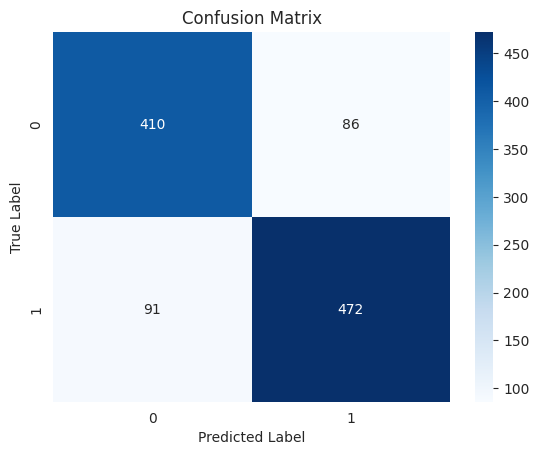

In [48]:
s = 'with'
evaluate(predictions1, ticker, s)

In [49]:
latest_prediction = predictions["Predictions"].iloc[-1]
latest_prediction

0.0

In [50]:
data1.to_csv(r'Output.csv')

# Organising the code

- Dividing code into functions for each part
- Having a central main function to run all parts of the code
- Providing a comprehensive output

In [1]:
def initialize(ticker):
  """
  Downloads historical stock data and initializes data structures.

  Args:
      ticker (str): The stock ticker symbol (e.g., "GOOGL").

  Returns:
      tuple: A tuple containing:
          - data (pd.DataFrame): The downloaded stock data.
          - data1 (pd.DataFrame): A dataframe with the 'Adj Close' column.
          - predictors (list): List of initial predictor columns.
          - full_predictors (list): List of all predictor columns including engineered features.
  """

  try:
      data = yf.download(ticker, start="2014-01-01", end="2023-12-31")
      print(f"\nInitialization: Data for {ticker} downloaded successfully.")
  except Exception as e:
      print(f"Error fetching data: {e}")

  data1 = data[["Adj Close"]]
  predictors = ["Adj Close", "Volume", "Open", "High", "Low","Close"]
  full_predictors = ["Adj Close", "Volume", "Open", "High", "Low","Close","weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean","weekly_trend","open_close_ratio","high_close_ratio","low_close_ratio"]

  return data, data1, predictors, full_predictors

In [2]:
def visualize(data):
  """
  Creates a line plot of the adjusted closing price trend.

  Args:
      data (pd.DataFrame): The stock data containing the 'Adj Close' column.

  Returns:
      None (displays the plot)
  """

  plt.figure(figsize=(12, 6))
  plt.plot(data.index, data["Adj Close"], color="blue", label="Adjusted Close")
  plt.title(f"Adjusted Closing Price Trend for {ticker}")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.grid(True)
  plt.show()

In [3]:
def data_manage(data1, data, predictors):
  """
  Performs data management tasks, such as creating target variable and merging lagged features.

  Args:
      data1 (pd.DataFrame): The dataframe to modify.
      data (pd.DataFrame): The original stock data.
      predictors (list): List of predictor columns.

  Returns:
      pd.DataFrame: The updated dataframe.
  """

  # data1["Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
  data1.loc[:, "Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
  data_prev = data.copy()
  data_prev = data_prev.shift(1)
  data1 = data1.merge(data_prev[predictors]).iloc[1:]
  return data1

In [4]:
# Feature Engineering: Calculate moving averages and ratios
def feature_eng(data1):
  """
  Performs feature engineering by calculating moving averages, ratios, and trends.

  Args:
      data1 (pd.DataFrame): The dataframe to modify.

  Returns:
      pd.DataFrame: The updated dataframe with engineered features.
  """

  weekly_mean = data1.rolling(7).mean()["Adj Close"]
  quarterly_mean = data1.rolling(90).mean()["Adj Close"]
  annual_mean = data1.rolling(365).mean()["Adj Close"]
  weekly_trend = data1.shift(1).rolling(7).sum()["Target"]
  data1["weekly_mean"] = weekly_mean / data1["Adj Close"]
  data1["quarterly_mean"] = quarterly_mean / data1["Adj Close"]
  data1["annual_mean"] = annual_mean / data1["Adj Close"]
  data1["annual_weekly_mean"] = data1["annual_mean"] / data1["weekly_mean"]
  data1["annual_quarterly_mean"] = data1["annual_mean"] / data1["quarterly_mean"]
  data1["weekly_trend"] = weekly_trend
  data1["open_close_ratio"] = data1["Open"] / data1["Close"]
  data1["high_close_ratio"] = data1["High"] / data1["Close"]
  data1["low_close_ratio"] = data1["Low"] / data1["Close"]

  return data1

In [5]:
# Defining the backtesting function
def backtest(data, model=None, predictors=None, start=1000, step=750):
    """
    Backtests a machine learning model on historical stock data.

    Args:
        data (pd.DataFrame): The input data containing stock prices and features.
        model: The machine learning model to use (default: HistGradientBoostingClassifier).
        predictors (list): List of predictor columns to use for training and prediction.
        start (int): The starting index for the backtesting loop.
        step (int): The step size for iterating through the data.

    Returns:
        pd.DataFrame: A DataFrame containing the backtest results.
    """

    if model is None:
        model = HistGradientBoostingClassifier()

    predictions = []


    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the model on the training data
        model.fit(train[predictors], train["Target"])

        # Make predictions on the test data
        preds = model.predict_proba(test[predictors])[:, 1]
        preds = pd.Series(preds, index=test.index)
        # Provide a threshold to buy/sell
        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [13]:
def evaluate(predictions, title):
  """
  Evaluates the performance of the machine learning model using various metrics.

  Args:
      predictions (pd.DataFrame): The backtest predictions.
      title (str): The title for the evaluation (usually the stock ticker).

  Returns:
      None (prints the evaluation results and displays the confusion matrix)
  """

  accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
  precision = precision_score(predictions["Target"], predictions["Predictions"])
  recall = recall_score(predictions["Target"], predictions["Predictions"])
  f1 = f1_score(predictions["Target"], predictions["Predictions"])
  roc_auc = roc_auc_score(predictions["Target"], predictions["Predictions"])
  confusion = confusion_matrix(predictions["Target"], predictions["Predictions"])
  classification = classification_report(predictions["Target"], predictions["Predictions"])

  print(f"\nAccuracy: {accuracy}\n")
  print(f"Precision: {precision}\n")
  print(f"Recall: {recall}\n")
  print(f"F1 Score: {f1}\n")
  print(f"ROC AUC Score: {roc_auc}\n")
  print(f"Classification Report: {classification}\n")

  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

In [19]:
def main(ticker):
  """
  Main function to orchestrate the stock price prediction process.

  Args:
      ticker (str): The stock ticker symbol.

  Returns:
      None
  """

  data, data1, predictors, full_predictors = initialize(ticker)
  visualize(data)
  data1 = data_manage(data1, data, predictors)
  data1 = feature_eng(data1)
  print('\n--- WITHOUT FEATURE ENGINEERING ---')
  predictions = backtest(data1[365:],None,predictors)
  evaluate(predictions, ticker)
  print('\n--- USING FEATURE ENGINEERING ---')
  predictions1 = backtest(data1[365:],None,full_predictors)
  evaluate(predictions1, ticker)

[*********************100%***********************]  1 of 1 completed



Initialization: Data for AXISBANK.NS downloaded successfully.


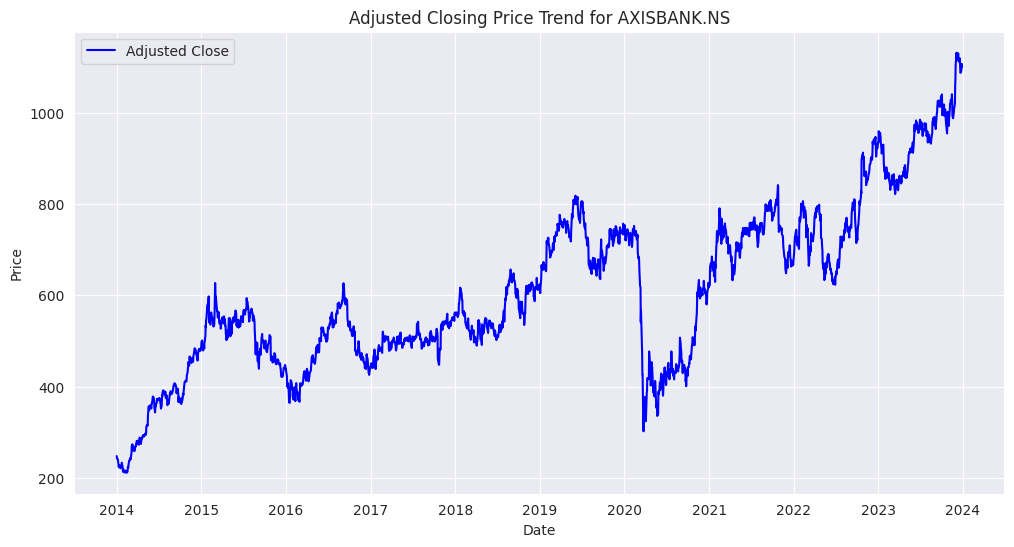

<ipython-input-3-57cc90f93c61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[:, "Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]



--- WITHOUT FEATURE ENGINEERING ---

Accuracy: 0.6244343891402715

Precision: 0.624133148404993

Recall: 0.6646971935007385

F1 Score: 0.6437768240343348

ROC AUC Score: 0.6235658540693214

Classification Report:               precision    recall  f1-score   support

         0.0       0.62      0.58      0.60       649
         1.0       0.62      0.66      0.64       677

    accuracy                           0.62      1326
   macro avg       0.62      0.62      0.62      1326
weighted avg       0.62      0.62      0.62      1326




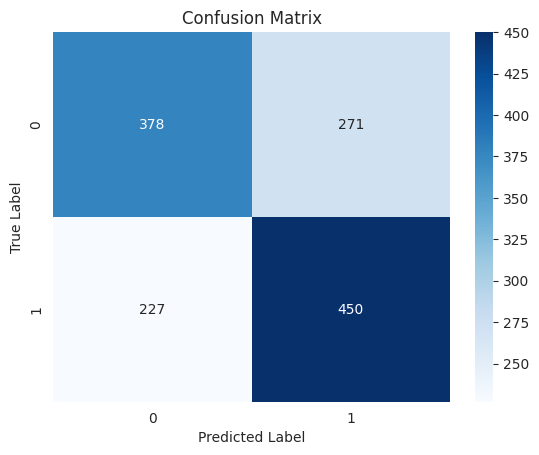


--- USING FEATURE ENGINEERING ---

Accuracy: 0.8295625942684767

Precision: 0.8585055643879174

Recall: 0.7976366322008862

F1 Score: 0.8269525267993875

ROC AUC Score: 0.8302512899062983

Classification Report:               precision    recall  f1-score   support

         0.0       0.80      0.86      0.83       649
         1.0       0.86      0.80      0.83       677

    accuracy                           0.83      1326
   macro avg       0.83      0.83      0.83      1326
weighted avg       0.83      0.83      0.83      1326




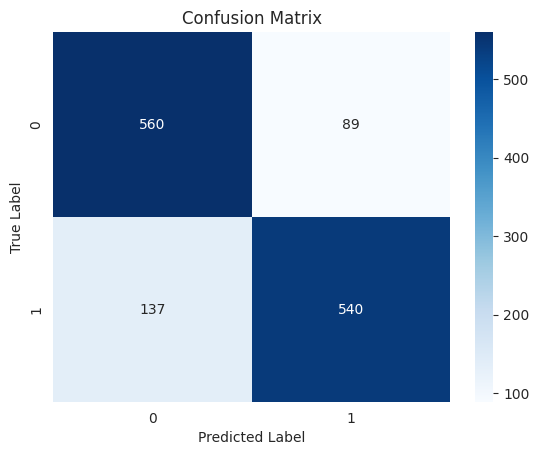

In [29]:
ticker = 'AXISBANK.NS'
main(ticker)

[*********************100%***********************]  1 of 1 completed



Initialization: Data for HDFCBANK.NS downloaded successfully.


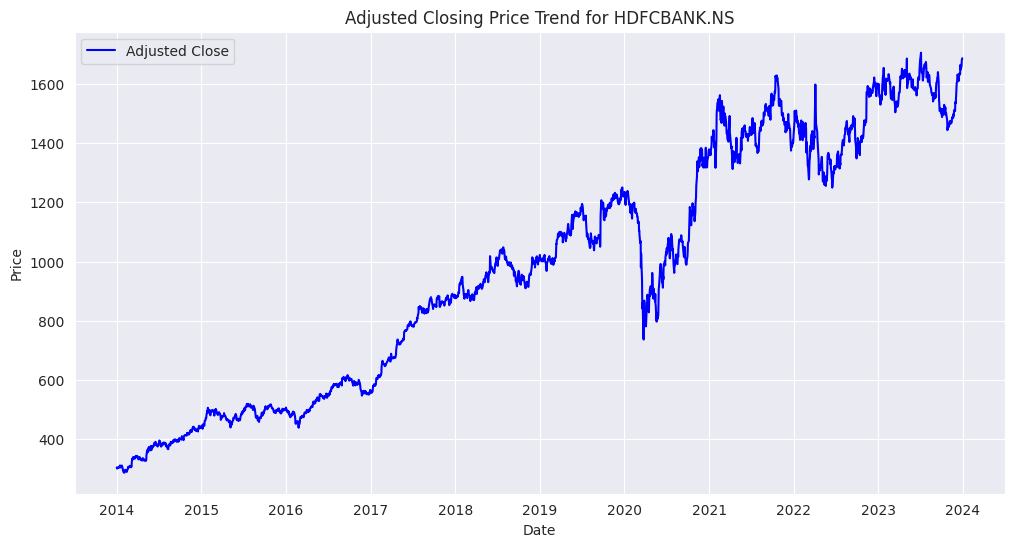

<ipython-input-3-57cc90f93c61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[:, "Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]



--- WITHOUT FEATURE ENGINEERING ---

Accuracy: 0.5567434210526315

Precision: 0.5616438356164384

Recall: 0.6518282988871225

F1 Score: 0.6033848417954378

ROC AUC Score: 0.5533417473992682

Classification Report:               precision    recall  f1-score   support

         0.0       0.55      0.45      0.50       587
         1.0       0.56      0.65      0.60       629

    accuracy                           0.56      1216
   macro avg       0.56      0.55      0.55      1216
weighted avg       0.56      0.56      0.55      1216




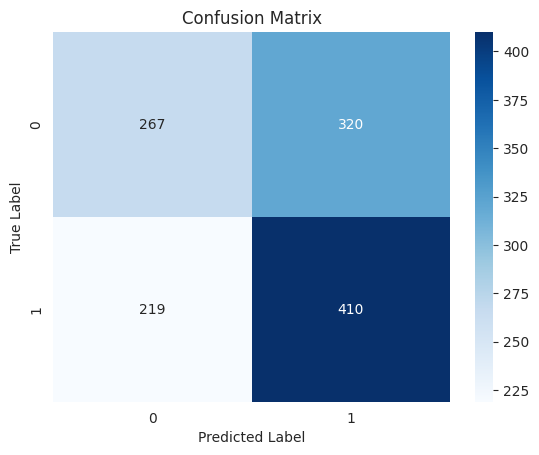


--- USING FEATURE ENGINEERING ---

Accuracy: 0.8108552631578947

Precision: 0.8202247191011236

Recall: 0.8124006359300477

F1 Score: 0.8162939297124601

ROC AUC Score: 0.8107999772495214

Classification Report:               precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       587
         1.0       0.82      0.81      0.82       629

    accuracy                           0.81      1216
   macro avg       0.81      0.81      0.81      1216
weighted avg       0.81      0.81      0.81      1216




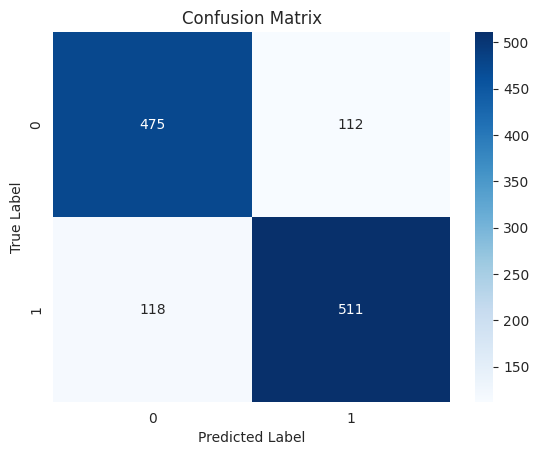

In [27]:
ticker = "HDFCBANK.NS"
main(ticker)

[*********************100%***********************]  1 of 1 completed



Initialization: Data for KOTAKBANK.NS downloaded successfully.


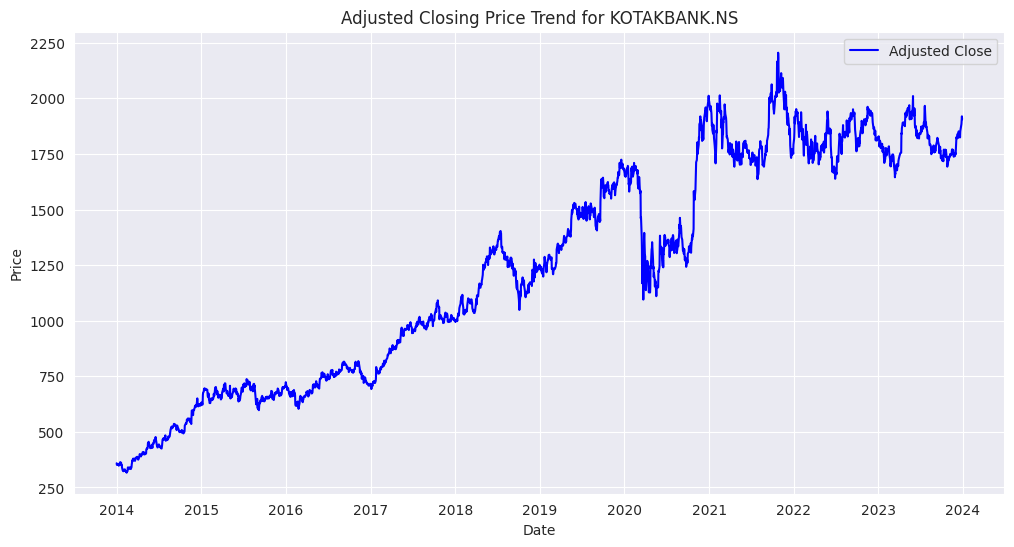

<ipython-input-3-57cc90f93c61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[:, "Target"] = data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]



--- WITHOUT FEATURE ENGINEERING ---

Accuracy: 0.6264367816091954

Precision: 0.6381909547738693

Recall: 0.614516129032258

F1 Score: 0.6261298274445357

ROC AUC Score: 0.6266560578271658

Classification Report:               precision    recall  f1-score   support

         0.0       0.62      0.64      0.63       598
         1.0       0.64      0.61      0.63       620

    accuracy                           0.63      1218
   macro avg       0.63      0.63      0.63      1218
weighted avg       0.63      0.63      0.63      1218




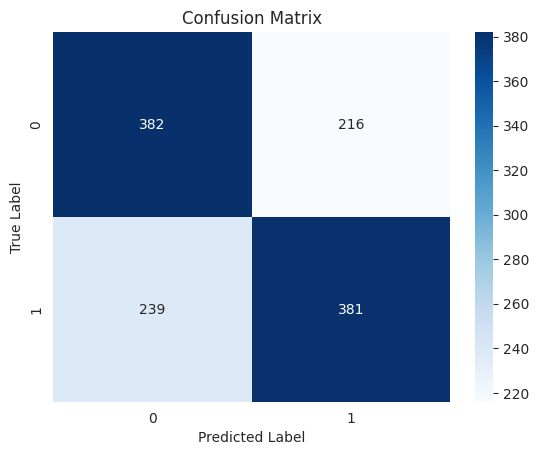


--- USING FEATURE ENGINEERING ---

Accuracy: 0.8308702791461412

Precision: 0.8415841584158416

Recall: 0.8225806451612904

F1 Score: 0.831973898858075

ROC AUC Score: 0.8310227640522171

Classification Report:               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       598
         1.0       0.84      0.82      0.83       620

    accuracy                           0.83      1218
   macro avg       0.83      0.83      0.83      1218
weighted avg       0.83      0.83      0.83      1218




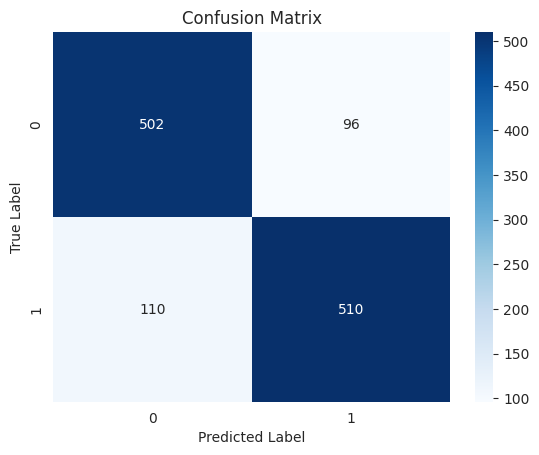

In [30]:
ticker = 'KOTAKBANK.NS'
main(ticker)